# Characterizing Clinical Text Using Clinical LLM Latent Representations
## Development Notebook

Summer 2023

SULI Internship: Ifrah Khurram

LBNL Mentors: Rafael Zamora-Resendiz, Silvia Crivelli Ph.D.

### Overview
This notebook serves as a tool to interact with large language model (LLM) embeddings of MIMIC-IV discharge reports.
In this exploratory work, we analyze 12-different LLM embeddings (of varied model size, input length, and
pretraining strategies) for 331,793 unique discharge reports existing in MIMIC-IV.
We have not yet explored the 2,299,451 unique radiology reports also found in MIMIC-IV.
This notebook implements some basic functionality to review the project results precomputed on NERSC's Perlmutter
and load renderings of the LLM latent spaces colored along common medical variables and 
ICD-coded Dx phenotypes.

### Purpose of Research
With increased interest in employing LLMs for clinical NLP and healthcare A.I., there is an increased 
need for tools to assess how LLMs organize medical information. In particular, the team is interested in how 
document respresentions by LLM correlate with structured medical variables used in clinical risk modeling. 
Current state-of-the-art (SOTA) models continue to show improved performance on broad NLP tasks by scaling 
LLM development to larger model sizes and pretraining corpuses. Even so, clinical LLM development lags behind 
results shown for LLMs trained on general internet corpuses such as GPT-3, GPT-4, BLOOM, etc.
This work takes a look at contemporary clinical LLMs and focuses on developing methods to assess the
clustering quality of LLM latent space w.r.t patient age, sex, race, life expectancy, fraility and
clinical phenotypes. Additonally, this suite of tools can be iteratively expanded to new medical variables
and LLMs.

### Precomputing LLM Embeddings, KMeans Clusters, & UMAP 2D

LLM inference was benchmarked and scaled on NERSC's Perlmutter. The table of benchmarking results can be found 
[here](https://github.com/CrivelliLab/OSA_Phenotyping_LLMs/tree/main#project-api). Each LLM was tested to 
see how many corpus documents can be embedded on the NVidia A100 GPUs hosted on Perlmutter. After the 
max throughput was found, the corpus was partitioned among `G` A100s where each worker `g` traverses 
a partition of the corpus in batches of max size `bs`. After the full corpus has been embedded at the document level, 
a grid search over KMeans clusterings and UMAP projections were computed on each embedding model.
The embeddings, clusters, and umap (x,y) coordinates can be found under `/global/cfs/cdirs/m1532/Projects_MVP/_models/embeds/LLMs/`.


#### Loading MIMIC-IV Dataset

In [1]:
#- Imports
import os, torch
import numpy as np
import pandas as pd
import seaborn as sns
import torch.nn.functional as F
from scipy.spatial.distance import cosine
import matplotlib.pyplot as plt
from IPython.display import Markdown

#-
MIMIC4_REPORTS = "/global/cfs/cdirs/m1532/Projects_MVP/_datasets/MIMIC_IV/physionet.org/files/mimic-iv-note/2.2/note/discharge.csv"
MIMIC4_ADMS = "/global/cfs/cdirs/m1532/Projects_MVP/_datasets/MIMIC_IV/physionet.org/files/mimiciv/2.2/hosp/admissions.csv"
MIMIC4_PATS = "/global/cfs/cdirs/m1532/Projects_MVP/_datasets/MIMIC_IV/physionet.org/files/mimiciv/2.2/hosp/patients.csv"
MIMIC4_DXS = "/global/cfs/cdirs/m1532/Projects_MVP/_datasets/MIMIC_IV/physionet.org/files/mimiciv/2.2/hosp/diagnoses_icd.csv"

#- Load MIMIC-IV Data
pats = pd.read_csv(MIMIC4_PATS)
pats["dob"] = pats.anchor_year - pats.anchor_age
pats = pats[["subject_id", "gender", "dob", "dod"]]
adms = pd.read_csv(MIMIC4_ADMS)
adms = adms[["subject_id", "hadm_id", "admittime", "dischtime", "deathtime", "admission_type", "race"]]
dxs = pd.read_csv(MIMIC4_DXS)
dxs = dxs.drop_duplicates(subset=["subject_id","hadm_id","seq_num"]).groupby(["subject_id", "hadm_id"]).icd_code.count().reset_index()
reports = pd.read_csv(MIMIC4_REPORTS)

#- Merge MIMIC-IV Data
df = adms.merge(pats, on="subject_id", how="left").reset_index(drop=True)
df["deathtime"] = pd.to_datetime(df.deathtime)
df["dod"] = pd.to_datetime(df.dod)
df["death"] = df[["deathtime","dod"]].max(axis=1)
df["dob"] = pd.to_datetime(df.dob.astype(str))
df["admittime"] = pd.to_datetime(df.admittime)
df["dischtime"] = pd.to_datetime(df.dischtime)
df["lifespan"] = (df.dod - df.dob).dt.days
df["from_birth"] = (df.dischtime - df.dob).dt.days
df["till_death"] = ((df.dod - df.admittime) / np.timedelta64(1, 'h')) * 60
df = df[["subject_id", "hadm_id", "admission_type", "gender", "race", "lifespan", "death", "from_birth", "till_death"]]
df = df.merge(dxs, on=["subject_id", "hadm_id"], how="left")
df = reports.merge(df, on=["subject_id", "hadm_id"], how="left")
df = df[["subject_id", "hadm_id", "note_id", "storetime", "text", "admission_type", "gender", "race", "lifespan", "death", "from_birth", "till_death", "icd_code"]]
del(pats); del(adms); del(dxs); del(reports)

#- Medical Variables
df["dead"] = 1 - df.death.isna().astype("int") # 1 is dead, 0 is alive
df["age"] = df.from_birth // 365.25 # binned by year; not enough resolution for days.
df["sex"] = (2*(df.gender == "M").astype("int")) + (df.gender == "F").astype("int") + 0 # 0 Missing, 1 is Female, 2 is Male ;
df["race"] = (2*df.race.str.contains("WHITE")) + df.race.str.contains("BLACK") + (~df.race.isna()).astype("int") # 0 Missing, 1 Other, 2 Black, 3 White
df["lifeexp"] = np.log10(np.clip(df.till_death, a_min=0, a_max=(60*24*365.25))) // 1.0 # Minutes remaining at time of admission, binned along log10
df["dxs"] = df.icd_code // 5.0 # Number of dxs per admission, binned by 5


/global/common/software/nersc/pm-2022q4/sw/pytorch/1.13.1/lib/python3.9/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


#### Loading LLM K-Means Clusters and 2D UMAPs

In [2]:
#- Latent Space Parameters
model = "Gatortron_s"
layer = 0 # idx from penultimate layer back
nb_neighbors = 256
min_dist = 0.001
nb_clusters = 256

#- Paths
EMBEDPATH = "/global/cfs/cdirs/m1532/Projects_MVP/_models/embeds/LLMs/{}.discharge.layer.{}/".format(model, layer)
UMAPPATH = "{}umap/nclusters.{}.nn.{}.min.{}.csv".format(EMBEDPATH, nb_clusters, nb_neighbors, min_dist)
KMEANSPATH = "{}kmeans/nclusters.{}.pt".format(EMBEDPATH, nb_clusters)

#- Load and Merge
kmeans = torch.load(KMEANSPATH)
umap = pd.read_csv(UMAPPATH)
umap = umap.rename(columns={"id":"note_id"}).sort_values("sha224").reset_index(drop=True)
latent = df.merge(umap, on="note_id", how="inner").reset_index(drop=True).reset_index().rename(columns={"index":"idx"})
totals = F.one_hot(kmeans.argmin(-1)).sum(0).float() 
clusters = F.one_hot(kmeans.argmin(-1), num_classes=len(totals))
latent = latent.sort_values("sha224").reset_index(drop=True)
latent["cluster"] = kmeans.argmin(-1).numpy()

In [3]:
print(latent.columns)
latent

Index(['idx', 'subject_id', 'hadm_id', 'note_id', 'storetime', 'text',
       'admission_type', 'gender', 'race', 'lifespan', 'death', 'from_birth',
       'till_death', 'icd_code', 'dead', 'age', 'sex', 'lifeexp', 'dxs',
       'sha224', 'umap_1', 'umap_2', 'cluster'],
      dtype='object')


,idx,subject_id,hadm_id,note_id,storetime,text,admission_type,gender,race,lifespan,...,icd_code,dead,age,sex,lifeexp,dxs,sha224,umap_1,umap_2,cluster
0,12592,10395376,21953495,10395376-DS-8,2171-12-23 17:10:00,\nName: ___. Unit No: ___\n...,ELECTIVE,M,3,NaN,...,5.0,0,54.0,2,NaN,1.0,000043fe317317e33b38cee8c5703a2222f34f18a869b0...,9.793646,-2.041272,99
1,174274,15259547,20733739,15259547-DS-20,2174-04-18 15:43:00,\nName: ___ Unit No: ___\n \nA...,EU OBSERVATION,F,3,NaN,...,4.0,0,53.0,1,NaN,0.0,000055a89a578246cae811ff56a69cc00fd46e99257999...,2.879043,-2.013247,255
2,265322,18001424,29978227,18001424-DS-13,2154-06-09 19:59:00,\nName: ___ Unit No: ___\n ...,EW EMER.,F,3,28042.0,...,14.0,1,76.0,1,5.0,2.0,0000cc5023b88c74cf99113f3ddb0d8f89c9c033f79835...,-2.591803,1.208107,235
3,153540,14634258,26672780,14634258-DS-18,2144-04-27 11:02:00,\nName: ___ Unit No: __...,EU OBSERVATION,M,3,NaN,...,5.0,0,59.0,2,NaN,1.0,000100f448b420083ce45bfdda8d2e9c601d255361024b...,9.025186,-1.820248,199
4,293672,18847983,22046751,18847983-DS-11,2165-05-13 21:10:00,\nName: ___ Unit No: ___\n \n...,EW EMER.,M,3,29841.0,...,34.0,1,81.0,2,5.0,6.0,000102afd8f815697a0c06c0ad599017b3b50f1b4cc811...,1.845838,-1.251720,59
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
331789,29473,10917585,21967413,10917585-DS-7,2129-12-30 13:01:00,\nName: ___ Unit No: ___\n \...,EW EMER.,F,3,27142.0,...,15.0,1,73.0,1,5.0,3.0,fffebfd3ba703ec21066154ca3952027bf1a426e87ce51...,2.254679,0.846382,239
331790,72662,12219997,28857189,12219997-DS-24,2139-03-14 22:30:00,\nName: ___ Unit No: ___\n...,ELECTIVE,M,3,NaN,...,5.0,0,64.0,2,NaN,1.0,ffff043b6f61e9a8648e111f488a3bdd98d66786fd3c1f...,0.165302,6.544990,39
331791,109779,13312840,22221709,13312840-DS-21,2141-04-29 13:34:00,\nName: ___ Unit No: ___\n...,EW EMER.,M,3,NaN,...,7.0,0,51.0,2,NaN,1.0,ffff26797afbec5840731ae83e6b64086e32606873eb3d...,-3.179442,-0.683144,87
331792,273362,18241426,29675306,18241426-DS-4,2178-09-22 12:59:00,\nName: ___ Unit No: ___\...,EW EMER.,M,1,NaN,...,6.0,0,28.0,2,NaN,1.0,ffff2891294dc0ebd22a2ebd05d13ea5c64f31b5c5a438...,9.388454,15.369526,181


#### Plotting UMAP With Variable

<AxesSubplot: xlabel='umap_1', ylabel='umap_2'>

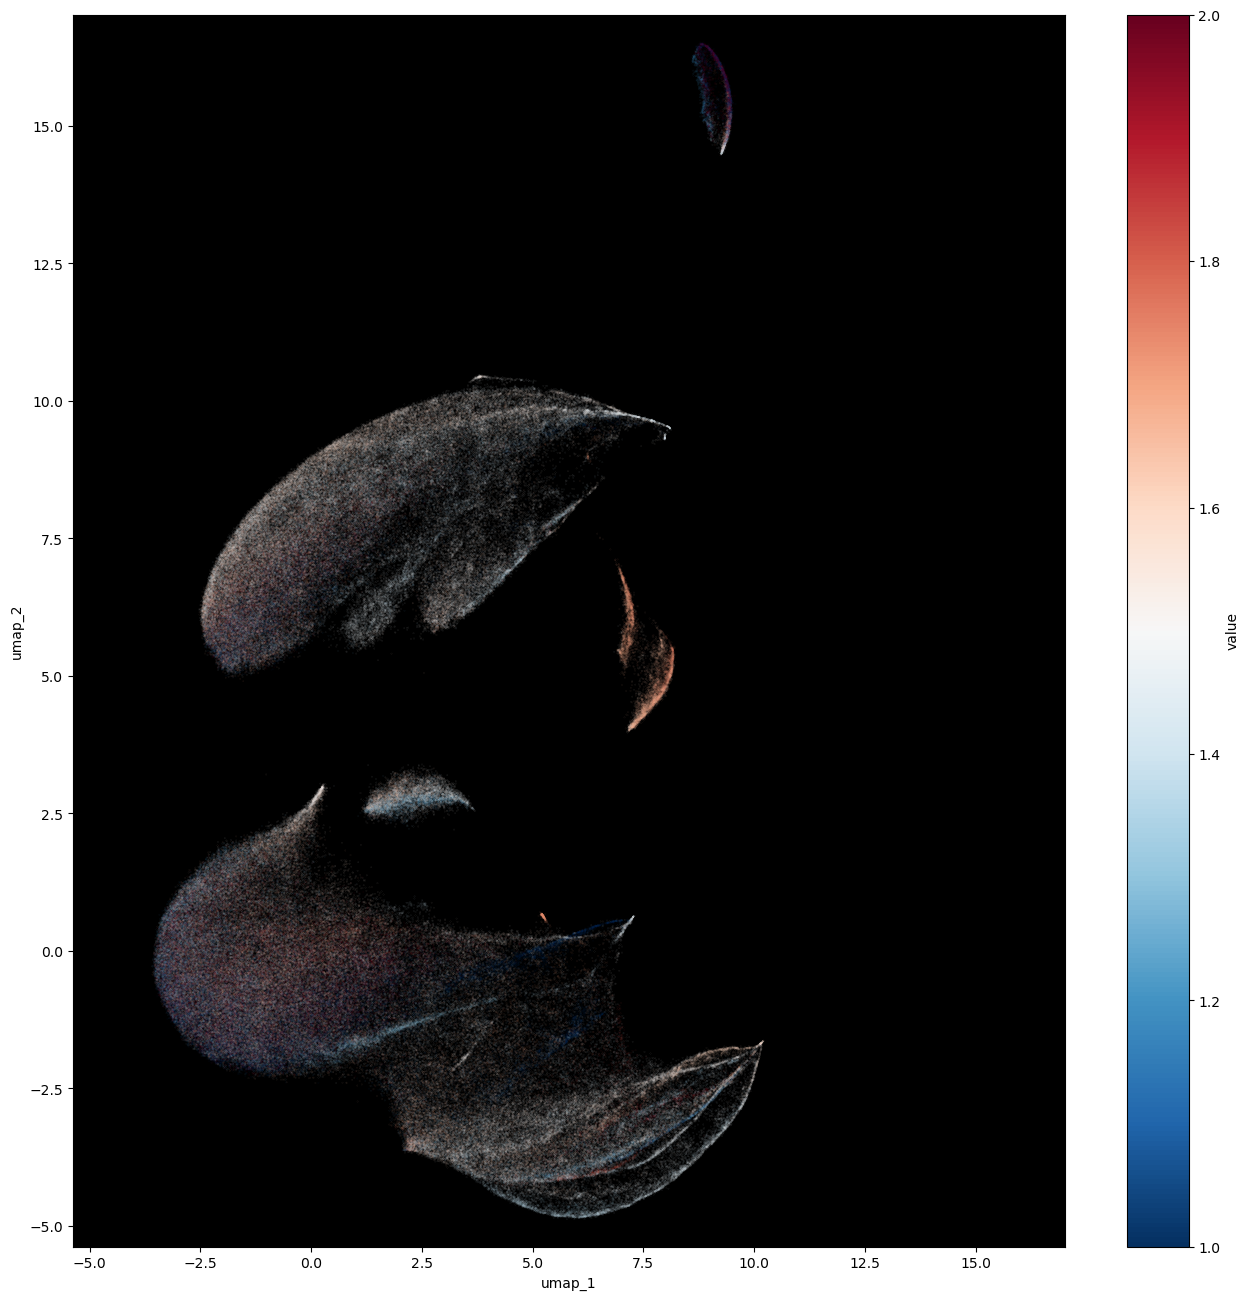

In [7]:
#-
var = "sex"

#- Render Scatter Plot
per_cluster = latent[["cluster", var]].groupby("cluster").mean().reset_index().rename(columns={var:"value"})
if "value" in latent.columns: latent = latent.drop(columns=["value"])
latent = latent.merge(per_cluster, on="cluster", how="left")
plot_args = {"x": "umap_1",
             "y": "umap_2",
             "c": "value",
             "alpha": 1.0,
             "s": 0.001,
             "cmap":"RdBu_r"}
plt.rcParams['figure.figsize'] = [16, 16]
ax = latent[~latent[var].isna()].plot.scatter(**plot_args)
minax = min(latent.umap_1.min(), latent.umap_2.min()) - 0.5
maxax = max(latent.umap_1.max(), latent.umap_2.max()) + 0.5
ax.set_xlim(minax,maxax)
ax.set_ylim(minax,maxax)
ax.set_facecolor('black')
ax

#### Rendering Clinical Text

In [ ]:
#- 
NOTEIDX = 0
print(latent.iloc[NOTEIDX])
display(Markdown(latent.iloc[NOTEIDX].text))